# Omitted Variable Bias Simulation

This notebook works through a simulation of omitted variable bias, letting us see firsthand how failing to account for an explanatory variable that is a part of the true data generating process affects our regression output.

## Data Generation

First we load some useful packages and set the seed for our random number generator (this chooses a starting point, allowing us all the get the same results when starting with the same seed). 

Then, we define some variables as random draws from normal distributions with certain means and specify our y as a linear combination of these variables with some noise.

$$ x_1 \sim N(0,1)$$
$$ x_2 \sim N(2,4)$$
$$x_3 \sim N(1,9)$$
$$x_4 = 2x_1 + N(0,1)$$
$$ x_5 = 3x_2 + N(0,1)$$
$$ y = 3x_1 + 2x_2 + x_4 + 1 + N(0,1) $$

We can see that 
* $x_1$, $x_2$, and $x_4$ are important for determining $y$
* $x_1$ and $x_4$ are highly correlated
* $x_3$ is irrelevant to $y$
* $x_5$ is also irrelevant to $y$ but is correlated to $x_2$


In [45]:
set.seed(3482)
library(tidyverse)

#Generate a data frame containing our variables
sim_df <- data.frame(
  x1 = rnorm(n = 1000, mean=0, sd=1), # x1 created as 1000 draws from an N(0,1) distribution
  x2 = rnorm(n=1000, mean=2, sd=2), # x1 created as 1000 draws from an N(2,4) distribution
  x3 = rnorm(n=1000, mean=1, sd=3))

#%>% # x3 created as "            " N(1,9) distribution
     # mutate(x4 = 2*x1 + rnorm(n=1000, mean=0, sd=1), 
     #       x5 = 3*x2 + rnorm(n=1000, mean=0, sd=1),
     #      y = 3*x1 + 2*x2 + x4 + 1 + rnorm(n=1000, mean=0, sd=1)) 

head(sim_df)
#cor(sim_df$x1, sim_df$x4)


sim_df <- sim_df %>%
            mutate(x4 = 2*x1 + rnorm(n=1000, mean=0, sd=1),
                 x5 = 3*x2 + rnorm(n=1000, mean=0, sd=1))
head(sim_df)

x1,x2,x3
<dbl>,<dbl>,<dbl>
-0.8520582,2.0794447,-4.335593
-0.3961602,2.7082643,3.958738
2.0534795,1.8599443,2.632375
-1.1005230,4.2316440,1.384193
0.3054607,0.9656828,2.435553
-1.8264013,6.0125898,-2.057048


x1,x2,x3,x4,x5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.8520582,2.0794447,-4.335593,-4.1265826,7.961427
-0.3961602,2.7082643,3.958738,-2.3322983,8.301227
2.0534795,1.8599443,2.632375,2.8337695,5.746812
-1.1005230,4.2316440,1.384193,-0.1248096,13.911016
0.3054607,0.9656828,2.435553,1.7065744,4.698512
-1.8264013,6.0125898,-2.057048,-4.7630230,18.218536


We see that $x_1$ and $x_4$ are highly positively correlated (0.89), and both relevant for explaining variation in $y$.

## Regression

We're simulating the classic omitted variable scenarios.

### 1. Full Knowledge of Data Generating Process


Call:
lm(formula = y ~ x1 + x2 + x4, data = sim_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3036 -0.6196  0.0148  0.6355  3.0332 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.00055    0.04282   23.36   <2e-16 ***
x1           3.08631    0.06797   45.41   <2e-16 ***
x2           2.00937    0.01540  130.50   <2e-16 ***
x4           0.97058    0.03010   32.24   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9674 on 996 degrees of freedom
Multiple R-squared:  0.9759,	Adjusted R-squared:  0.9758 
F-statistic: 1.345e+04 on 3 and 996 DF,  p-value: < 2.2e-16


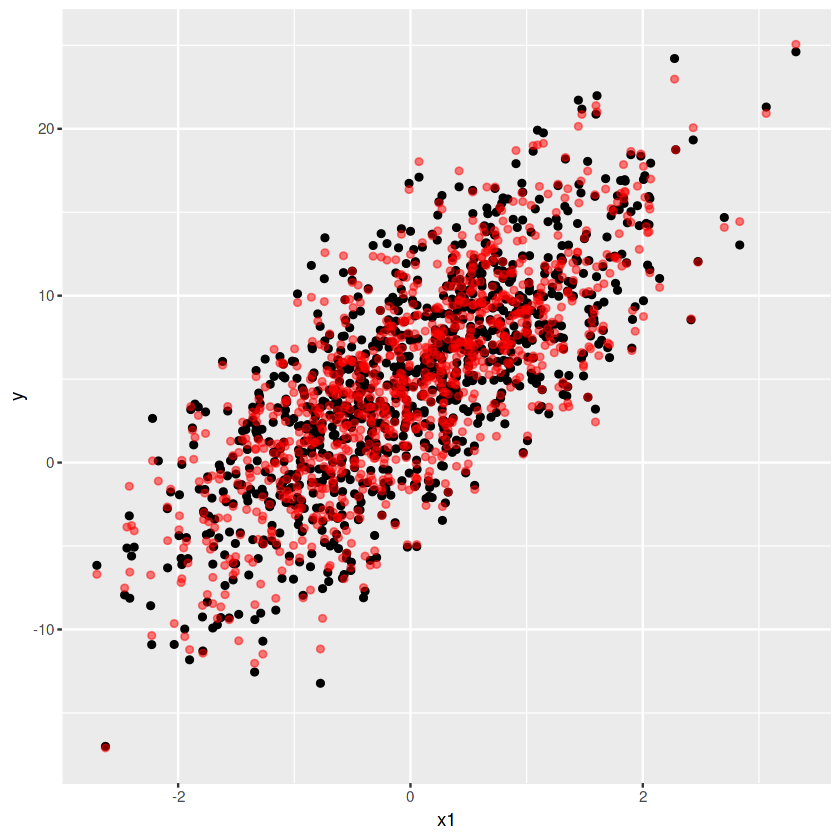

In [37]:
# Regression with full knowledge of data generating process

true_model <- lm(y ~ x1 + x2 + x4, data = sim_df)
summary(true_model)

sim_df <- sim_df %>%
mutate(yhat_true = true_model$fitted.values)
ggplot(sim_df) + 
  geom_point(aes(x1, y)) + 
geom_point(aes(x1, yhat_true), colour = "red", alpha = 0.5)



### 2. Include an Irrelevant Variable that is (nearly) Uncorrelated with X's

Now let's see what happens when we add $x_3$, a variable that's not part of the data-generating process for $y$ and is also not correlated with any of the other independent variables.

[1] 0.02007967

[1] -0.001134037


Call:
lm(formula = y ~ x1 + x2 + x3 + x4, data = sim_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2989 -0.6251  0.0192  0.6368  3.0487 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.995066   0.044373  22.425   <2e-16 ***
x1          3.085948   0.068003  45.380   <2e-16 ***
x2          2.009146   0.015411 130.370   <2e-16 ***
x3          0.004891   0.010301   0.475    0.635    
x4          0.970742   0.030114  32.235   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9678 on 995 degrees of freedom
Multiple R-squared:  0.9759,	Adjusted R-squared:  0.9758 
F-statistic: 1.008e+04 on 4 and 995 DF,  p-value: < 2.2e-16


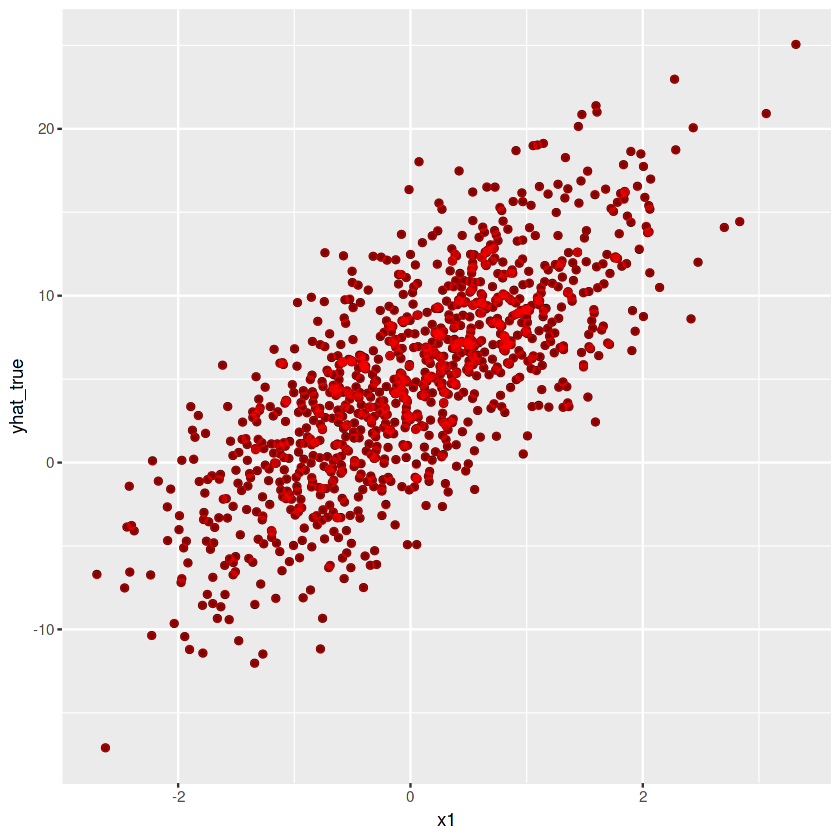

In [38]:
cor(sim_df$x3, sim_df$y)
cor(sim_df$x3, sim_df$x1)
overspec_model <- lm(y ~ x1 + x2 + x3 + x4, data = sim_df)
summary(overspec_model)

sim_df <- sim_df %>%
mutate(yhat_overspec = overspec_model$fitted.values)

ggplot(sim_df) + 
  geom_point(aes(x1, yhat_true)) + 
  geom_point(aes(x1, yhat_overspec), colour = "red", alpha = 0.5)


And we see that our coefficients on relevant explanatory variables are essentially unchanged, and we predict the null effect for $x_3$. Our fitted values look nearly identical to what we had before

### 3. Include an Irrelevant Variable that is Correlated with X

Here we add $x_5$ into our estimation, a variable that is irrelevant for $y$ but is correlated with the relevant variable $x_2$.


Call:
lm(formula = y ~ x1 + x2 + x5 + x4, data = sim_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3170 -0.6205  0.0045  0.6368  3.0430 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.00091    0.04284  23.364   <2e-16 ***
x1           3.08565    0.06800  45.377   <2e-16 ***
x2           1.95149    0.09361  20.848   <2e-16 ***
x5           0.01921    0.03065   0.627    0.531    
x4           0.97044    0.03011  32.229   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9677 on 995 degrees of freedom
Multiple R-squared:  0.9759,	Adjusted R-squared:  0.9758 
F-statistic: 1.008e+04 on 4 and 995 DF,  p-value: < 2.2e-16


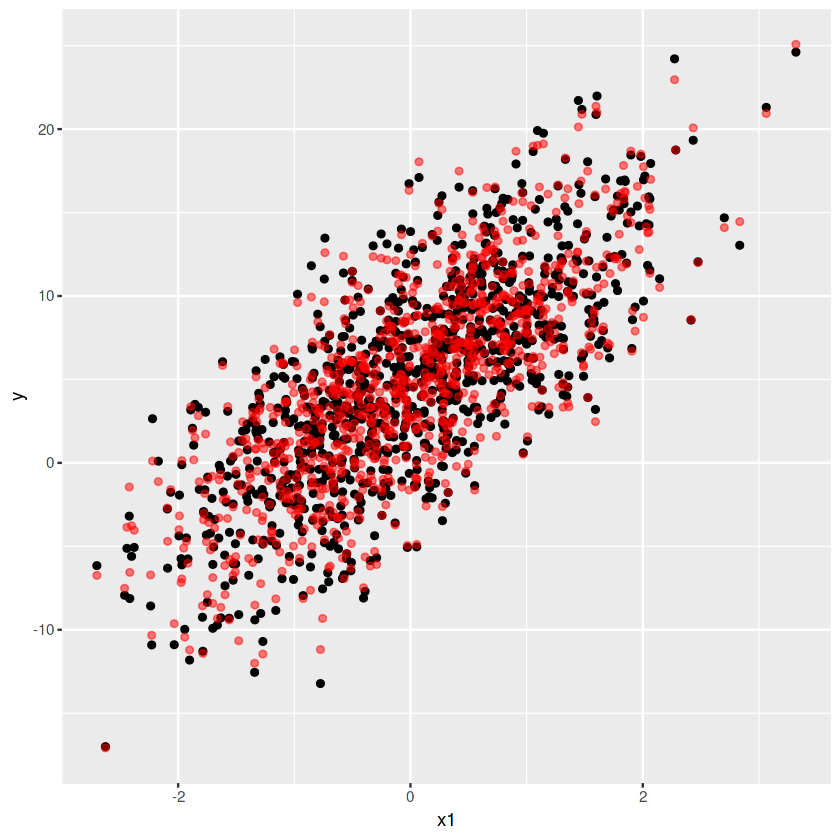

In [39]:
irrel_model <- lm(y ~ x1 + x2 + x5 + x4, data = sim_df)
summary(irrel_model)

sim_df <- sim_df %>%
mutate(yhat_irrel = irrel_model$fitted.values)

ggplot(sim_df) + 
  geom_point(aes(x1, y)) + 
  geom_point(aes(x1, yhat_irrel), colour = "red", alpha = 0.5)


### 4. Omit an important variable that is correlated to x

Now let's see what happens to our estimation when we omit $x_4$, a variable that is important for determining $y$ _and_ strongly correlated with $x_1$.


Call:
lm(formula = y ~ x1 + x2, data = sim_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3034 -0.9372  0.0037  0.9589  4.2649 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.07005    0.06111   17.51   <2e-16 ***
x1           5.03862    0.04414  114.15   <2e-16 ***
x2           1.96902    0.02193   89.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.382 on 997 degrees of freedom
Multiple R-squared:  0.9508,	Adjusted R-squared:  0.9507 
F-statistic:  9624 on 2 and 997 DF,  p-value: < 2.2e-16


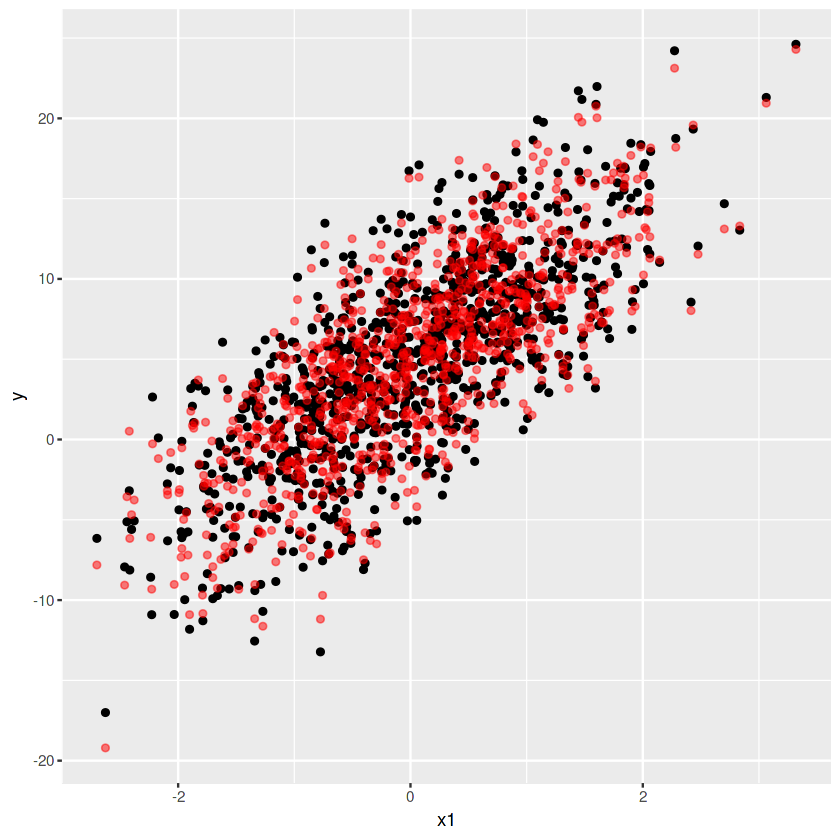

In [40]:
# OVB Model 

ovb_model <- lm(y ~ x1 + x2, data = sim_df)
summary(ovb_model)

sim_df <- sim_df %>%
mutate(yhat_ovb = ovb_model$fitted.values)
ggplot(sim_df) + 
  geom_point(aes(x1, y)) + 
  geom_point(aes(x1, yhat_ovb), colour = "red", alpha = 0.5)


Now we estimate $\hat{\beta}_1 = 5.03$, which is not equal to the true $\beta = 3.

Why do we have upward bias? Well we know 

* $Cov(x_1, y) > 0$
* $Cov(x_1, x_4) > 0$

So the sign of the bias is positive as well, as it is determined by the product of these two objects.